In [59]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.parametrize as parametrize
import torch.utils.data as tdata

import matplotlib.pyplot as plt
from random import sample

In [56]:
# Convert the grayscale images to binary images
class Binarize(object):
    def __init__(self, threshold):
        self.threshold = threshold / 255

    def __call__(self, img):
        return (img > self.threshold).to(img.dtype)


# Down sampling the images from 28x28 to 7x7 and binarize them
transforms = v2.Compose([
    v2.Resize((7, 7), antialias=False),
    v2.ToDtype(torch.int8, scale=True),
    Binarize(128),
])

train = datasets.MNIST(root='./data', train=True, download=True)
test = datasets.MNIST(root='./data', train=False, download=True)

# Overwriting train and test dataset just with '0' and '1' classes
train.data = train.data[train.targets <= 1]
train.targets = train.targets[train.targets <= 1]

test.data = test.data[test.targets <= 1]
test.targets = test.targets[test.targets <= 1]

# Not sure why the 'transforms' is not getting applied above
train.data = transforms(train.data)
test.data = transforms(test.data)

In [40]:
sum(test.targets == 1)

tensor(1135)

In [42]:
len(test.targets)

2115

In [41]:
sum(test.targets == 0)

tensor(980)

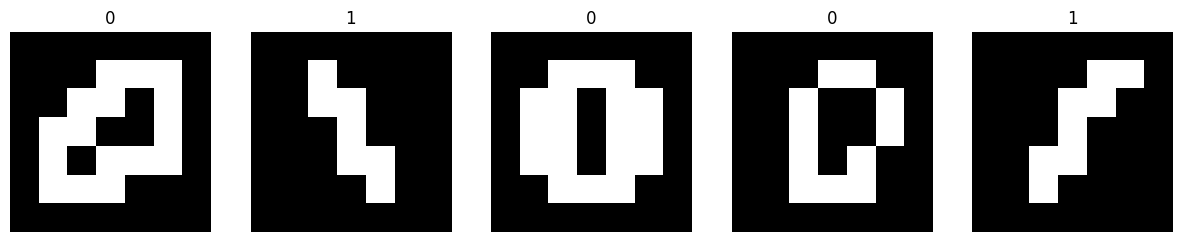

In [3]:
# Viewing a few random samples from the transformed dataset

fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, j in enumerate(sample(range(len(train.data)), 5)):
    ax[i].imshow(train.data[j], cmap='gray')
    ax[i].set_title(train.targets[j].item())
    ax[i].axis('off')
plt.show()

In [5]:
train.data[0]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], dtype=torch.int8)

In [43]:
class shiftedReLU(nn.ReLU):
    def __init__(self, shift: float = 0.4, inplace: bool = False):
        super(shiftedReLU, self).__init__(inplace)
        self.shift = shift

    def forward(self, input):
        return F.relu(input - self.shift, self.inplace)


# Defining the MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(49, 32)
        self.fc2 = nn.Linear(32, 1)
        self.srelu = shiftedReLU(shift=0.5)

    def forward(self, x):
        x = x.view(-1, 49)
        # x = F.relu(self.fc1(x))
        x = self.srelu(self.fc1(x))
        x = self.fc2(x)

        return x

In [44]:
# Loading the model

# DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
DEVICE = 'cpu'
model = MLP()
model.load_state_dict(torch.load('models/fp32_clipped.pth'))
model.to(DEVICE)
model.eval()

MLP(
  (fc1): Linear(in_features=49, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (srelu): shiftedReLU()
)

6.395127296447754
0.0
0.0
6.395127296447754
0.0


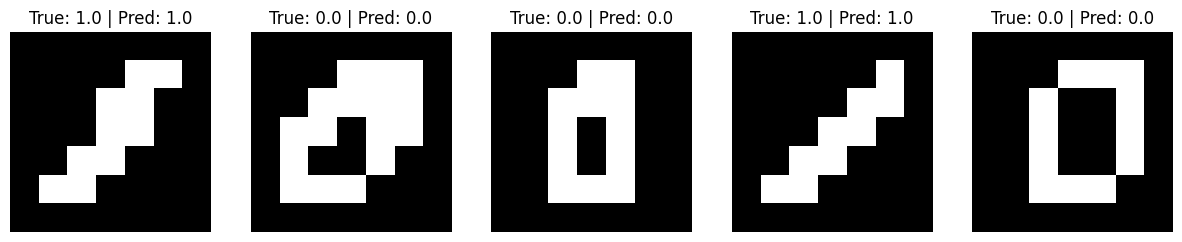

In [50]:
# Viewing the Predictions

fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, j in enumerate(sample(range(len(test.data)), 5)):
    data, target = test.data[j].float().to(DEVICE), test.targets[j].float().to(DEVICE)
    output = model(data)
    print(output.item())
    predicted = (output > 0).float()
    ax[i].imshow(test.data[j], cmap='gray')
    ax[i].set_title(f'True: {target.item()} | Pred: {predicted.item()}')
    ax[i].axis('off')
plt.show()

99.72%

In [63]:
# Print the weights of the model

for name, param in model.named_parameters():
    print(name, param)
    
# Export the parameters as numpy arrays to a file

fc1.weight Parameter containing:
tensor([[0.0060, 0.1493, 0.0000,  ..., 0.1834, 0.0000, 0.0000],
        [0.0609, 0.2453, 0.0000,  ..., 0.2185, 0.0000, 0.0152],
        [0.0944, 0.0000, 1.0056,  ..., 0.3372, 0.0000, 0.0413],
        ...,
        [0.0394, 0.2407, 0.0000,  ..., 0.2485, 0.0000, 0.1242],
        [0.1106, 0.1386, 0.0000,  ..., 0.2228, 0.0085, 0.0627],
        [0.0843, 0.2027, 0.0000,  ..., 0.2490, 0.0000, 0.0347]],
       requires_grad=True)
fc1.bias Parameter containing:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0018,
        0.0646, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0364, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], requires_grad=True)
fc2.weight Parameter containing:
tensor([[0.0000, 0.0000, 0.9422, 0.0000, 0.0000, 0.0000, 0.0000, 0.0875, 1.5634,
         0.1311, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9456, 0.0000, 0.0947,
       

In [13]:
# 8-bit quantization

model_int8 = torch.ao.quantization.quantize_dynamic(
    model,
    {nn.Linear},
    dtype=torch.qint8)

torch.save(model_int8, 'models/int8.pth')

RuntimeError: Didn't find engine for operation quantized::linear_prepack NoQEngine

In [60]:
# Testing the clipped model

test = tdata.TensorDataset(test.data.unsqueeze(1).float(), test.targets.float())
test_loader = tdata.DataLoader(test, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        # print(output)
        predicted = (output > 0).float()
        total += target.size(0)
        correct += (predicted == target.unsqueeze(1)).sum().item()

print(f'Accuracy: {correct / total * 100:.2f}%')

Accuracy: 80.57%
